In [1]:
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
df = pd.read_csv('timeseries_cell.csv')

### Prepare data for neural network

In [3]:
time_steps = []
observations = []
counter = 0

df_i = df.iloc[::4, :]
   
for index, row in df_i.iterrows(): 
    observations.append(float(row['nr_people']))
    time_steps.append(int(counter))
    counter+=1

In [4]:
def plot_the_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time span")
    plt.ylabel("Observations")
    plt.grid(True)

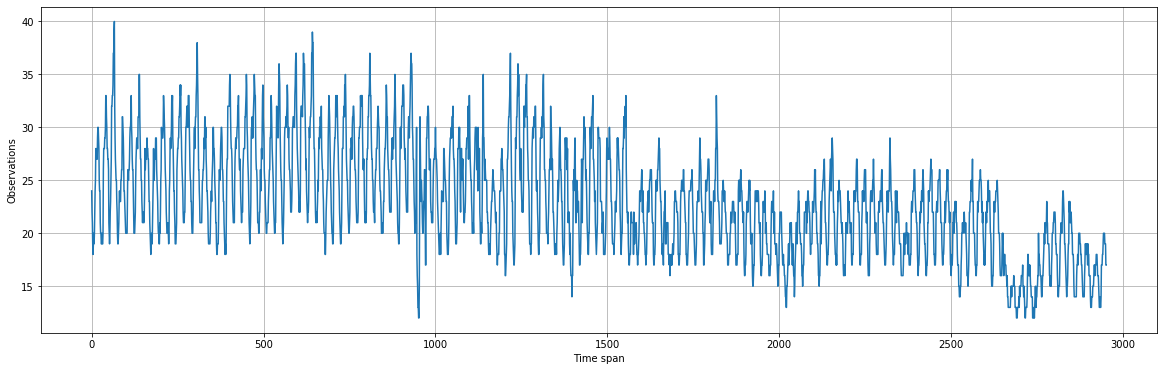

In [5]:
series = np.array(observations)
time = np.array(time_steps)
plt.figure(figsize=(20, 6))
plot_the_series(time, series)

In [6]:
split_time = 2100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 60
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2100,)


In [9]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,strides=1, padding="causal",
                      activation="relu", input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 30)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=150, callbacks=[lr_schedule])

Epoch 1/150
8/8 [==============================] - 1s 161ms/step - loss: 23.0040 - mae: 23.5040 - lr: 1.0000e-08
Epoch 2/150
8/8 [==============================] - 1s 153ms/step - loss: 22.9975 - mae: 23.4975 - lr: 1.1220e-08
Epoch 3/150
8/8 [==============================] - 1s 152ms/step - loss: 22.9873 - mae: 23.4873 - lr: 1.2589e-08
Epoch 4/150
8/8 [==============================] - 1s 155ms/step - loss: 22.9745 - mae: 23.4745 - lr: 1.4125e-08
Epoch 5/150
8/8 [==============================] - 1s 152ms/step - loss: 22.9596 - mae: 23.4596 - lr: 1.5849e-08
Epoch 6/150
8/8 [==============================] - 1s 153ms/step - loss: 22.9427 - mae: 23.4427 - lr: 1.7783e-08
Epoch 7/150
8/8 [==============================] - 1s 152ms/step - loss: 22.9237 - mae: 23.4237 - lr: 1.9953e-08
Epoch 8/150
8/8 [==============================] - 1s 153ms/step - loss: 22.9025 - mae: 23.4025 - lr: 2.2387e-08
Epoch 9/150
8/8 [==============================] - 1s 155ms/step - loss: 22.8786 - mae: 23.3786 

8/8 [==============================] - 1s 166ms/step - loss: 3.4675 - mae: 3.9403 - lr: 3.9811e-05
Epoch 74/150
8/8 [==============================] - 1s 159ms/step - loss: 3.4002 - mae: 3.8732 - lr: 4.4668e-05
Epoch 75/150
8/8 [==============================] - 2s 228ms/step - loss: 3.3813 - mae: 3.8541 - lr: 5.0119e-05
Epoch 76/150
8/8 [==============================] - 1s 172ms/step - loss: 3.3507 - mae: 3.8232 - lr: 5.6234e-05
Epoch 77/150
8/8 [==============================] - 1s 161ms/step - loss: 3.4064 - mae: 3.8797 - lr: 6.3096e-05
Epoch 78/150
8/8 [==============================] - 1s 163ms/step - loss: 3.5055 - mae: 3.9799 - lr: 7.0795e-05
Epoch 79/150
8/8 [==============================] - 1s 160ms/step - loss: 3.4999 - mae: 3.9743 - lr: 7.9433e-05
Epoch 80/150
8/8 [==============================] - 1s 165ms/step - loss: 3.3386 - mae: 3.8115 - lr: 8.9125e-05
Epoch 81/150
8/8 [==============================] - 1s 153ms/step - loss: 3.3099 - mae: 3.7824 - lr: 1.0000e-04
Epoch

8/8 [==============================] - 1s 166ms/step - loss: 93.6504 - mae: 94.1504 - lr: 0.1995
Epoch 148/150
8/8 [==============================] - 1s 173ms/step - loss: 105.1783 - mae: 105.6783 - lr: 0.2239
Epoch 149/150
8/8 [==============================] - 2s 193ms/step - loss: 118.1402 - mae: 118.6402 - lr: 0.2512
Epoch 150/150
8/8 [==============================] - 1s 178ms/step - loss: 132.4504 - mae: 132.9504 - lr: 0.2818


### Visualize network architecture

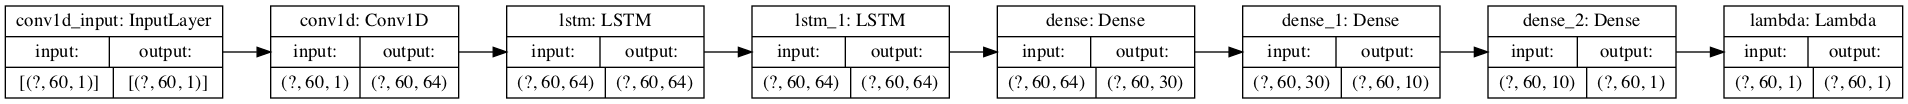

In [10]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir="LR")

[1e-08, 0.1, 0, 200]

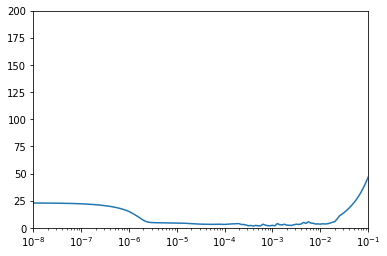

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 200], figsize = (15, 5))


### Train with the right learning rate, window and batch size

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 168
batch_size = 328
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,strides=1, padding="causal",
                      activation="relu", input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 30)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=150)

Epoch 1/150
6/6 [==============================] - 3s 459ms/step - loss: 22.1228 - mae: 22.6228
Epoch 2/150
6/6 [==============================] - 3s 460ms/step - loss: 18.2060 - mae: 18.7060
Epoch 3/150
6/6 [==============================] - 3s 471ms/step - loss: 12.2256 - mae: 12.7249
Epoch 4/150
6/6 [==============================] - 3s 457ms/step - loss: 6.2936 - mae: 6.7748
Epoch 5/150
6/6 [==============================] - 3s 460ms/step - loss: 4.2995 - mae: 4.7798
Epoch 6/150
6/6 [==============================] - 3s 480ms/step - loss: 4.5839 - mae: 5.0656
Epoch 7/150
6/6 [==============================] - 3s 476ms/step - loss: 4.4574 - mae: 4.9390
Epoch 8/150
6/6 [==============================] - 3s 481ms/step - loss: 4.0266 - mae: 4.5056
Epoch 9/150
6/6 [==============================] - 3s 477ms/step - loss: 3.8620 - mae: 4.3372
Epoch 10/150
6/6 [==============================] - 3s 483ms/step - loss: 3.9098 - mae: 4.3888
Epoch 11/150
6/6 [==============================] - 3

6/6 [==============================] - 4s 698ms/step - loss: 2.4954 - mae: 2.9561
Epoch 88/150
6/6 [==============================] - 3s 482ms/step - loss: 2.4555 - mae: 2.9158
Epoch 89/150
6/6 [==============================] - 3s 487ms/step - loss: 2.4389 - mae: 2.8992
Epoch 90/150
6/6 [==============================] - 3s 502ms/step - loss: 2.4042 - mae: 2.8640
Epoch 91/150
6/6 [==============================] - 3s 537ms/step - loss: 2.3741 - mae: 2.8337
Epoch 92/150
6/6 [==============================] - 3s 559ms/step - loss: 2.3431 - mae: 2.8024
Epoch 93/150
6/6 [==============================] - 5s 764ms/step - loss: 2.3133 - mae: 2.7719
Epoch 94/150
6/6 [==============================] - 4s 597ms/step - loss: 2.2947 - mae: 2.7531
Epoch 95/150
6/6 [==============================] - 4s 591ms/step - loss: 2.2699 - mae: 2.7281
Epoch 96/150
6/6 [==============================] - 4s 585ms/step - loss: 2.2400 - mae: 2.6976
Epoch 97/150
6/6 [==============================] - 3s 570ms/st

### Plot model with the new input 

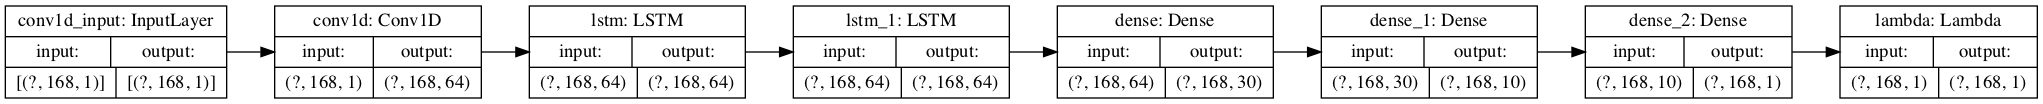

In [18]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir="LR")

No handles with labels found to put in legend.


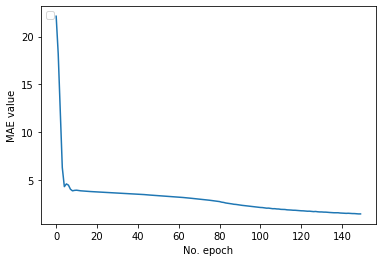

In [19]:
plt.plot(history.history['loss'], label='')

plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [20]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
forecast = forecast[split_time - window_size:-1, -1, 0]

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

1.4310682

### Compute RMSE

In [22]:
import math 
math.sqrt(tf.keras.metrics.mean_squared_error(x_valid, forecast).numpy())

1.7449305540765239

### Visualize forecast vs test data

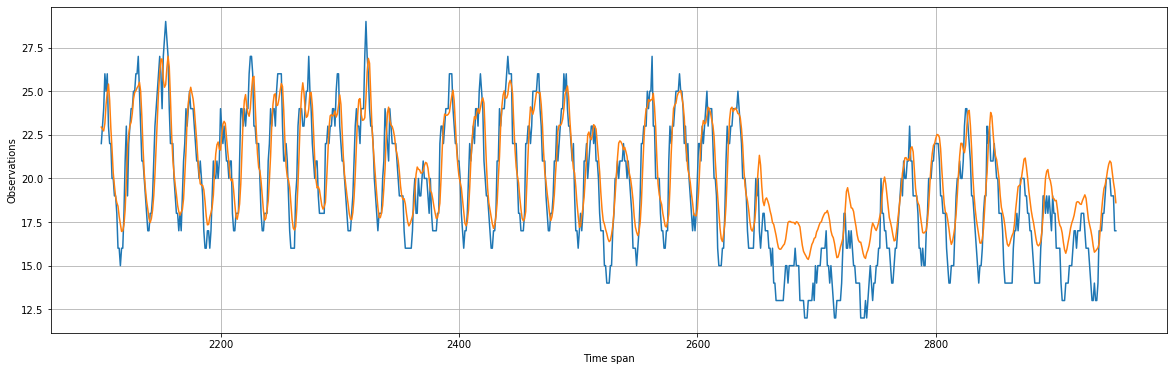

In [23]:
plt.figure(figsize=(20, 6))
plot_the_series(time_valid, x_valid)
plot_the_series(time_valid, forecast)